#                                            Reverse Image Search

In [1]:

import requests
import os
import numpy as np
from numpy.linalg import norm
import joblib as pickle
from tqdm import tqdm
import os
import PIL
import time
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import gc
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
#from tensorflow.keras.applications.MobileNet import MobileNetV2,preprocess_input
#from tensorflow.keras.applications.mobilenet import MobileNet,preprocess_input
import math
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.decomposition import PCA

In [2]:
img_size =224

model = ResNet50(weights='imagenet', include_top=False,input_shape=(img_size, img_size, 3),pooling='max')

94773248/94765736 [==============================] - 3s 0us/step


Create the keras image data generator object and extract the features for the images using Resnet50 predict_generator method.

In [3]:
batch_size = 64
root_dir = '/kaggle/input/caltech101/101_ObjectCategories'

img_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

datagen = img_gen.flow_from_directory(root_dir,
                                        target_size=(img_size, img_size),
                                        batch_size=batch_size,
                                        class_mode=None,
                                        shuffle=False)

num_images = len(datagen.filenames)
num_epochs = int(math.ceil(num_images / batch_size))

feature_list = model.predict_generator(datagen, num_epochs,verbose = 1)

Found 9144 images belonging to 102 classes.
143/143 [==============================] - 71s 496ms/step


In [4]:
print("Num images   = ", len(datagen.classes))
print("Shape of feature_list = ", feature_list.shape)

Num images   =  9144
Shape of feature_list =  (9144, 2048)


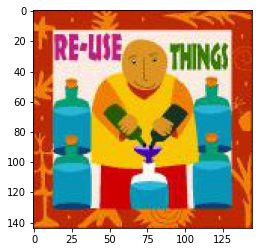

In [5]:
plt.imshow(plt.imread('/kaggle/input/caltech101/101_ObjectCategories/BACKGROUND_Google/image_0001.jpg'))
plt.show()

We have 9144 images in our dataset. Each image is converted into a 2048 feature vector.

In [6]:
# Get full path for all the images in our dataset

filenames = [root_dir + '/' + s for s in datagen.filenames]

In [7]:
neighbors = NearestNeighbors(n_neighbors=5,
                             algorithm='ball_tree',
                             metric='euclidean')
neighbors.fit(feature_list)

NearestNeighbors(algorithm='ball_tree', leaf_size=30, metric='euclidean',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

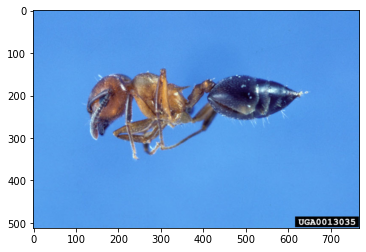

In [8]:
plt.imshow(plt.imread('/kaggle/input/ant-and-bee/hymenoptera_data/train/ants/0013035.jpg'))
plt.show()

In [9]:
img_path = '/kaggle/input/ant-and-bee/hymenoptera_data/train/ants/0013035.jpg'
# ref https://datascience.stackexchange.com/questions/31167/how-to-predict-an-image-using-saved-model
input_shape = (img_size, img_size, 3)
img = image.load_img(img_path, target_size=(input_shape[0], input_shape[1]))
img_array = image.img_to_array(img)
expanded_img_array = np.expand_dims(img_array, axis=0)
preprocessed_img = preprocess_input(expanded_img_array)


In [10]:
test_img_features = model.predict(preprocessed_img, batch_size=1)

_, indices = neighbors.kneighbors(test_img_features)

(1, 5)


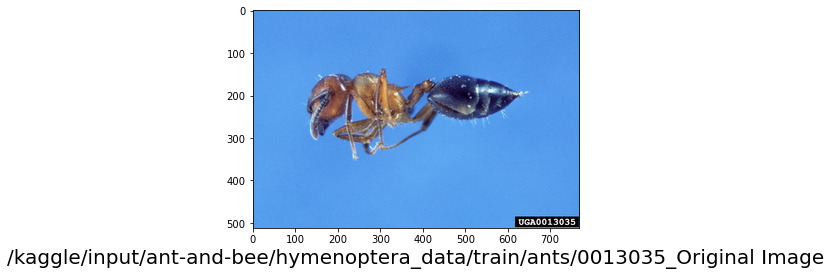

********* Predictions ***********


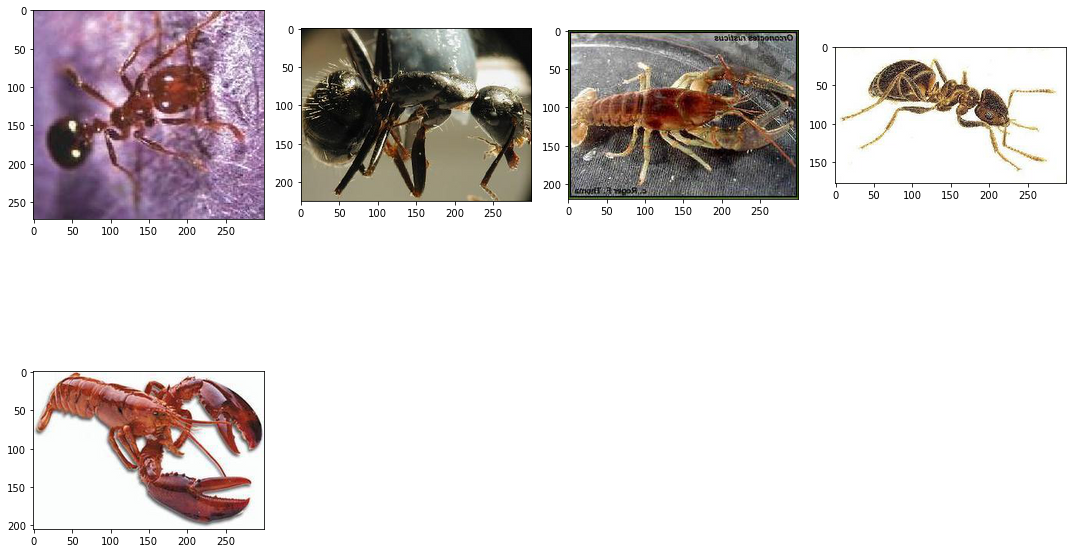

In [11]:
def similar_images(indices):
    plt.figure(figsize=(15,10), facecolor='white')
    plotnumber = 1    
    for index in indices:
        if plotnumber<=len(indices) :
            ax = plt.subplot(2,4,plotnumber)
            plt.imshow(mpimg.imread(filenames[index]), interpolation='lanczos')            
            plotnumber+=1
    plt.tight_layout()

print(indices.shape)

plt.imshow(mpimg.imread(img_path), interpolation='lanczos')
plt.xlabel(img_path.split('.')[0] + '_Original Image',fontsize=20)
plt.show()
print('********* Predictions ***********')
similar_images(indices[0])

Here we observe image a of scorpion in the prediction which is incorrect. Due to the large dimensionality of the features, the NearestNeighbors algorithm is not able to cluster similar features accurately.

<br>
To overcome this we will apply PCA to our features and reduce the dimensions and try to find the similar features again.

In [12]:
pca = PCA(n_components=100)
pca.fit(feature_list)
compressed_features = pca.transform(feature_list)

In [13]:
neighbors_pca_features = NearestNeighbors(n_neighbors=5,
                             algorithm='ball_tree',
                             metric='euclidean').fit(compressed_features)

(1, 5)


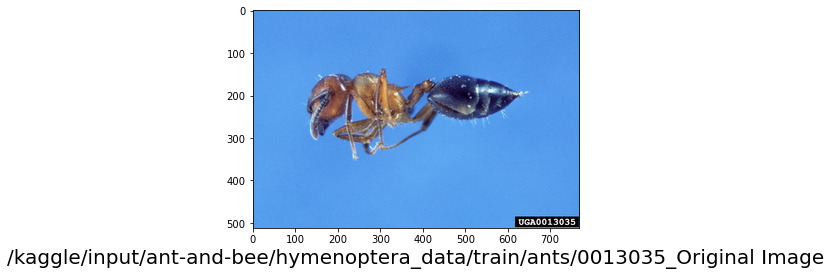

********* Predictions ***********


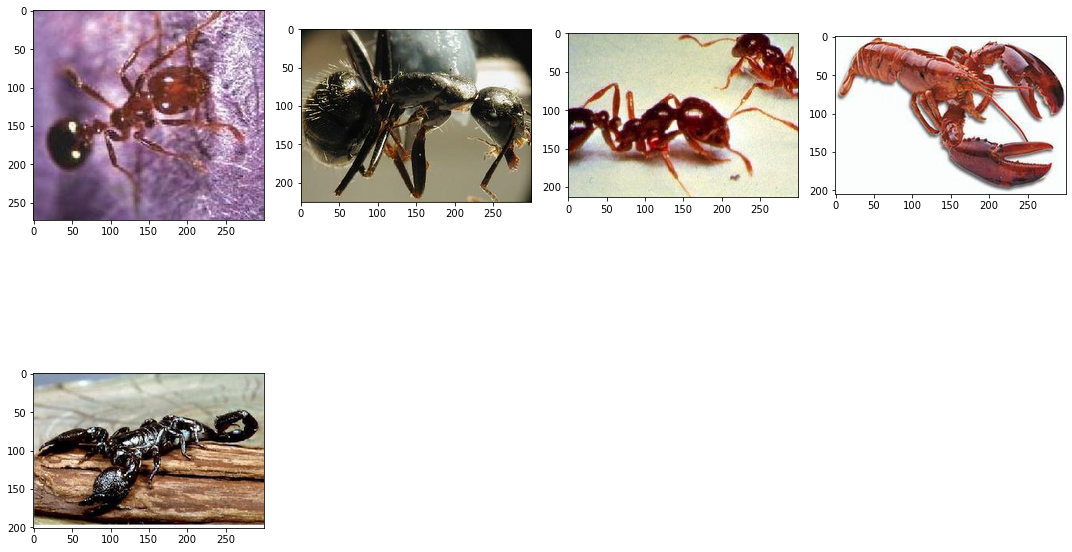

In [14]:
test_img_compressed = pca.transform(test_img_features)
distances, indices = neighbors_pca_features.kneighbors(test_img_compressed)
print(indices.shape)
plt.imshow(mpimg.imread(img_path), interpolation='lanczos')
plt.xlabel(img_path.split('.')[0] + '_Original Image',fontsize=20)
plt.show()
print('********* Predictions ***********')
similar_images(indices[0])

Great! Decreasing the dimensions of the feature helped us in getting better results.